导入模块

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt 
from sklearn.metrics import auc,roc_curve,roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

pd.options.display.max_columns = None

# 原始数据处理

In [2]:
# 从附件3中读取行的中文名称
retitle = pd.read_excel('Data/附件3.xlsx')
retitle.drop(columns='单位',inplace=True)
retitle.head()
temprename = retitle.to_dict(orient ='records' )
rename_dic = {}
for i in temprename:
    rename_dic[i['字段名']] = i['含义']
    
# 重命名附件2中的所有行名为中文名
data = pd.read_csv('Data/附件2.csv')
data.rename(columns=rename_dic,inplace=True)

去除缺失值超过50%，方差为0的列

In [3]:
# 手动计算缺失值
nullrate=pd.DataFrame()
nullrate['isnull_number'] = data.isnull().sum()
nullrate['all'] = data.shape[0]
nullrate['rate'] = nullrate['isnull_number'] / nullrate['all']

# 除去缺失值超过50%的特征
data.drop(columns=nullrate[nullrate.rate>0.50].index,inplace=True)

# 除去标准差为0的特征
des = data.describe().T
data.drop(columns=des[des['std']==0].index,inplace=True)

data.drop(columns=['会计准则','货币代码','报告类型'],inplace=True)

取出数据

In [4]:
X = data[data.是否在当年造假.isnull()==False].drop(columns='是否在当年造假')
Y = data.是否在当年造假.dropna()
# 需要预测的数据
pre_X = data[data.是否在当年造假.isnull()==True].drop(columns='是否在当年造假')

导出数据备用

In [5]:
X.to_csv('Data/X.csv',index=False,encoding='utf_8_sig')
pre_X.to_csv('Data/pre_X.csv',index=False,encoding='utf_8_sig')
Y.to_csv('Data/Y.csv',index=False,encoding='utf_8_sig')

# 标准化处理对于学习结果的影响

In [7]:
X = pd.read_csv('Data/X.csv')
pre_X = pd.read_csv('Data/pre_X.csv')
Y = pd.read_csv('Data/Y.csv')

用0填充缺失值  
对于财务报表数据而言，有些缺失值并非缺失值，该企业不涉及到对应的科目的，为空，因此，采用0来对缺失值进行填充。

In [8]:
X.fillna(0,inplace=True)

测试、训练集划分

In [9]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=123)

In [10]:
y_train.value_counts()

是否在当年造假
0.0        13404
1.0          141
dtype: int64

可见，预测样本存在明显的偏斜，造假的样本占比非常少。

## 不进行标准化默认参数逻辑回归

默认参数逻辑回归

D:\python37\Lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


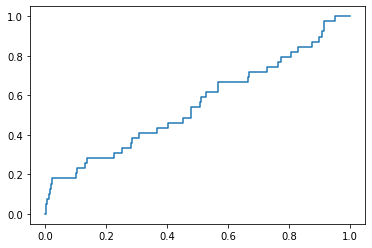

auc: 0.5519465640109072


In [12]:
lg = LogisticRegression(C=100000000000000000,)
lg.fit(x_train,y_train.values.ravel())
fpr, tpr, thres = roc_curve(y_test, lg.predict_proba(x_test)[:,1])

plt.plot(fpr, tpr)
plt.show()

score = roc_auc_score(y_test, lg.predict_proba(x_test)[:,1])
print('auc:',score)

## 标准化后逻辑回归

In [14]:
X = pd.read_csv('Data/X.csv')
pre_X = pd.read_csv('Data/pre_X.csv')
Y = pd.read_csv('Data/Y.csv')
X.fillna(0,inplace=True)
x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=123)
y_train.value_counts()

是否在当年造假
0.0        13404
1.0          141
dtype: int64

In [15]:
# 数据标准化
s = StandardScaler()
s.fit(x_train)
x_train_s = s.transform(x_train)
x_test_s = s.transform(x_test)

In [16]:
pre_X_s = s.transform(pre_X)
pre_X_s= pd.DataFrame(columns=pre_X.columns,data =pre_X_s)

In [17]:
x_train_s = pd.DataFrame(columns=x_train.columns,data = x_train_s)
x_test_s= pd.DataFrame(columns=x_test.columns,data = x_test_s)

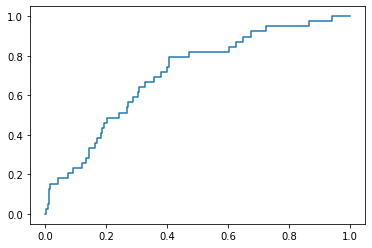

auc: 0.707110286198758


In [18]:
lg = LogisticRegression(max_iter=10000000000)
lg.fit(x_train_s,y_train.values.ravel())

fpr, tpr, thres = roc_curve(y_test, lg.predict_proba(x_test_s)[:,1])

plt.plot(fpr, tpr)
plt.show()

score = roc_auc_score(y_test, lg.predict_proba(x_test_s)[:,1])
print('auc:',score)

对比未进行标准化前的auc，标准化处理后auc提升明显，因此，选择进行标准化，将标准化后的数据导出备用

In [20]:
x_train_s.to_csv('Data/x_train_s.csv',index=False,encoding='utf_8_sig')
x_test_s.to_csv('Data/x_test_s.csv',index=False,encoding='utf_8_sig')
y_train.to_csv('Data/y_train.csv',index=False,encoding='utf_8_sig')
y_test.to_csv('Data/y_test.csv',index=False,encoding='utf_8_sig')
pre_X_s.to_csv('Data/pre_X_s.csv',index=False,encoding='utf_8_sig')

# 绘制学习曲线

In [22]:
x_train_s = pd.read_csv('Data/x_train_s.csv')
x_test_s = pd.read_csv('Data/x_test_s.csv')
y_train = pd.read_csv('Data/y_train.csv')
y_test = pd.read_csv('Data/y_test.csv')

In [23]:

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    return plt

In [31]:
lg = LogisticRegression(max_iter=10000000000)

<module 'matplotlib.pyplot' from 'D:\\python37\\Lib\\site-packages\\matplotlib\\pyplot.py'>

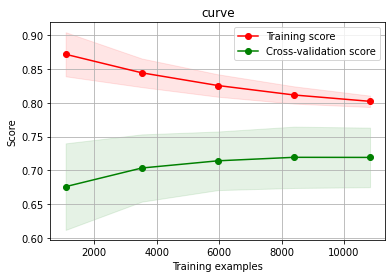

In [34]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(lg, 'curve', x_train_s, y_train.values.ravel(), cv=cv, n_jobs=1)

In [25]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

通过学习曲线，当前模型存在高方差问题，存在一定的过拟合问题，解决思路
- 增加样本（尝试过采样）
- 减少特征（特征选择）
- 提高正则化参数

## 增加样本（过采样）

In [24]:
x_train_s = pd.read_csv('Data/x_train_s.csv')
x_test_s = pd.read_csv('Data/x_test_s.csv')
y_train = pd.read_csv('Data/y_train.csv')
y_test = pd.read_csv('Data/y_test.csv')

In [25]:
smo=SMOTE(random_state=0)
x_train_smo,y_train_smo=smo.fit_resample(x_train_s,y_train)

In [26]:
y_train_smo.value_counts()

是否在当年造假
0.0        13404
1.0        13404
dtype: int64

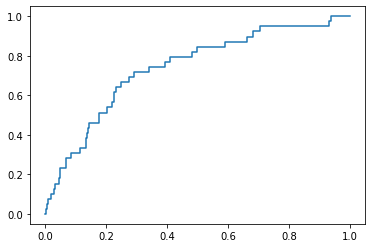

auc: 0.7395110102884901


In [27]:
lg = LogisticRegression(max_iter=10000000000)
lg.fit(x_train_smo,y_train_smo.values.ravel())

fpr, tpr, thres = roc_curve(y_test, lg.predict_proba(x_test_s)[:,1])

plt.plot(fpr, tpr)
plt.show()

score = roc_auc_score(y_test, lg.predict_proba(x_test_s)[:,1])
print('auc:',score)

采取过采用后，auc提升，后续继续采取过采样

<module 'matplotlib.pyplot' from 'D:\\python37\\Lib\\site-packages\\matplotlib\\pyplot.py'>

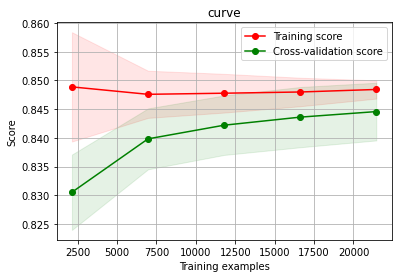

In [40]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(lg, 'curve', x_train_smo, y_train_smo.values.ravel(), cv=cv, n_jobs=1)

## 使用模型选择特征

In [29]:
x_train_s = pd.read_csv('Data/x_train_s.csv')
x_test_s = pd.read_csv('Data/x_test_s.csv')
y_train = pd.read_csv('Data/y_train.csv')
y_test = pd.read_csv('Data/y_test.csv')

smo=SMOTE(random_state=0)
x_train_smo,y_train_smo=smo.fit_resample(x_train_s,y_train)

In [30]:
x_train_smo.drop(columns=['股票代码'],inplace=True)
x_test_s.drop(columns=['股票代码'],inplace=True)

使用随机森林选取

In [35]:

# 使用默认参数
rf = RandomForestClassifier(random_state=0)
rf.fit(x_train_smo,y_train_smo.values.ravel())
rf_imp = pd.DataFrame({'feature_name':x_train_smo.columns,'feature_importances':rf.feature_importances_})

In [36]:
rf_imp = rf_imp.sort_values(by='feature_importances',ascending=False)
rf_imp.head(50)

,feature_name,feature_importances
76,稀释每股收益,0.052406
81,基本每股收益,0.037359
94,营业外支出,0.034742
29,其他应付款,0.030781
38,未分配利润,0.027135
19,其他非流动资产,0.026221
22,短期借款,0.023533
35,实收资本(或股本),0.022092
3,截止日期,0.021711
44,支付其他与筹资活动有关的现金,0.021136


auc: 0.7091267386173552
auc: 0.7087371966728535
auc: 0.7084335830984624
auc: 0.7304197887307807
auc: 0.7309926445315185
auc: 0.7320696134369056
auc: 0.7323159414312228
auc: 0.7287928782566853
auc: 0.7286897642125524
auc: 0.7283116793840654
auc: 0.729669347631814
auc: 0.7297781902339543
auc: 0.7293600054994156
auc: 0.7292798056873124
auc: 0.7294459338695263
auc: 0.7287241355605967
auc: 0.7317774569785293
auc: 0.7335647670768314
auc: 0.7352604202470154
auc: 0.7155828234916707
auc: 0.7166139639329988
auc: 0.7181091175729245
auc: 0.7182408744070943
auc: 0.7180575605508582
auc: 0.7179716321807474
auc: 0.7248516303476089
auc: 0.7261290987832543
auc: 0.7265701977498225
auc: 0.7262207557113723
auc: 0.7297724616759469
auc: 0.729136591737128
auc: 0.7298469329300428
auc: 0.7522226805068628
auc: 0.7522284090648702
auc: 0.7455317247542448
auc: 0.7457895098645768
auc: 0.7456291102403703
auc: 0.7439678284182306
auc: 0.7385256983112212
auc: 0.7467404504938018
auc: 0.746866478769964
auc: 0.747032606952

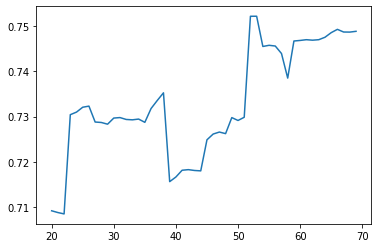

In [48]:
def return_auc(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train.values.ravel())
    fpr, tpr, thres = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    score = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
    print('auc:',score)
    return score


all_i =[]
auc_score = []

# 选取前不同特征数量时候auc的变化
lg = LogisticRegression(max_iter=10000000000,random_state=0)
for i in range(20,70):
    all_i.append(i)
    rf_slf = list(rf_imp[:i].feature_name)
    auc_score.append(return_auc(lg,x_train_smo[rf_slf],y_train_smo,x_test_s[rf_slf],y_test))

i_auc = pd.DataFrame({'select_feature_num':all_i,'auc':auc_score}).sort_values(by='auc',ascending=False)
plt.plot(all_i,auc_score)
    

In [49]:
i_auc.sort_values(by='auc',ascending=False).head(1)

,select_feature_num,auc
33,53,0.752228


发现在选择53个特征的时候auc最高

In [50]:
rf_slf = list(rf_imp[:53].feature_name)

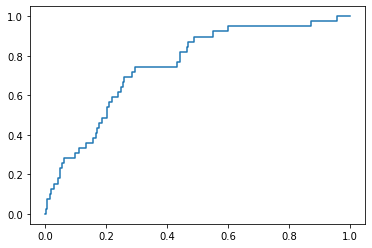

auc: 0.7522284090648702


In [51]:
lg = LogisticRegression(max_iter=10000000000,random_state=0)
lg.fit(x_train_smo[rf_slf],y_train_smo.values.ravel())

fpr, tpr, thres = roc_curve(y_test, lg.predict_proba(x_test_s[rf_slf])[:,1])

plt.plot(fpr, tpr)
plt.show()

score = roc_auc_score(y_test, lg.predict_proba(x_test_s[rf_slf])[:,1])
print('auc:',score)

逻辑回归模型调参

In [61]:
lg = LogisticRegression(max_iter=10000000,random_state=0)

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
param = {'C':[0.001,0.01,0.03,0.08,1,10,100]}

gs = GridSearchCV(lg,param_grid=param,scoring='roc_auc',cv=cv)

gs_result = gs.fit(x_train_smo[rf_slf],y_train_smo.values.ravel())

In [62]:
gs_result.cv_results_

{'mean_fit_time': array([0.07589831, 0.16300182, 0.23144057, 0.35302391, 0.84821243,
        2.05821583, 4.57874596]),
 'std_fit_time': array([0.00601464, 0.01725076, 0.02825437, 0.03985696, 0.08450033,
        0.12243436, 0.89716999]),
 'mean_score_time': array([0.00528853, 0.005583  , 0.00508313, 0.00593362, 0.00498345,
        0.0050343 , 0.00578179]),
 'std_score_time': array([0.00045301, 0.00111119, 0.00053765, 0.00138523, 0.0006306 ,
        0.00064744, 0.00116355]),
 'param_C': masked_array(data=[0.001, 0.01, 0.03, 0.08, 1, 10, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.03},
  {'C': 0.08},
  {'C': 1},
  {'C': 10},
  {'C': 100}],
 'split0_test_score': array([0.78748566, 0.81625957, 0.82104819, 0.82339071, 0.82903609,
        0.83144446, 0.83159872]),
 'split1_test_score': array([0.78805744, 0.81584194, 0.8211716 , 0.82435688, 0.83201821,
        

根据结果可知，在惩罚系数C=100时，模型效果更好。  
但是，在sklearn的逻辑回归模型中，C为正则化系数的倒数，C越大正则化越弱，即降低了正则化参数。  
尝试C=100的模型

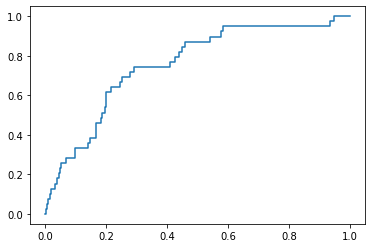

auc: 0.7553963016429504


In [63]:
lg = LogisticRegression(max_iter=10000000000,random_state=0,C=100)
lg.fit(x_train_smo[rf_slf],y_train_smo.values.ravel())

fpr, tpr, thres = roc_curve(y_test, lg.predict_proba(x_test_s[rf_slf])[:,1])

plt.plot(fpr, tpr)
plt.show()

score = roc_auc_score(y_test, lg.predict_proba(x_test_s[rf_slf])[:,1])
print('auc:',score)

调参后在测试集中的提升并不大，考虑更换模型尝试

## 更换学习模型-随机森林

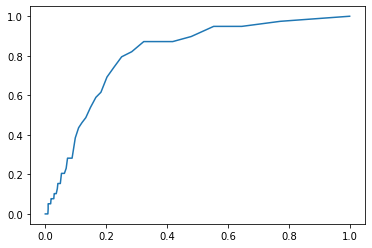

auc: 0.8081362709378795


In [64]:
# 随机森林默认参数回归
rf = RandomForestClassifier(random_state=0)
rf.fit(x_train_smo[rf_slf],y_train_smo.values.ravel())

fpr, tpr, thres = roc_curve(y_test, rf.predict_proba(x_test_s[rf_slf])[:,1])

plt.plot(fpr, tpr)
plt.show()

score = roc_auc_score(y_test, rf.predict_proba(x_test_s[rf_slf])[:,1])
print('auc:',score)

在选取了相同特征的情况下，随机森林的表现好于逻辑回归，更换随机森林进行调参

In [65]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

param = {'n_estimators':[100,300,500,700]}

gs = GridSearchCV(rf,param_grid=param,scoring='roc_auc',cv=cv)

gs_result = gs.fit(x_train_smo[rf_slf],y_train_smo.values.ravel())

In [66]:
gs_result.cv_results_

{'mean_fit_time': array([ 18.18509212,  56.20736818, 103.6636539 , 110.35155973]),
 'std_fit_time': array([0.33844487, 8.39218698, 8.92352599, 2.0819262 ]),
 'mean_score_time': array([0.14624386, 0.41878777, 0.89141779, 0.82023878]),
 'std_score_time': array([0.00941699, 0.07223616, 0.16849197, 0.04316924]),
 'param_n_estimators': masked_array(data=[100, 300, 500, 700],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 100},
  {'n_estimators': 300},
  {'n_estimators': 500},
  {'n_estimators': 700}],
 'split0_test_score': array([0.99987115, 0.99988417, 0.99988403, 0.99988605]),
 'split1_test_score': array([0.9999161 , 0.9999353 , 0.99993168, 0.99993509]),
 'split2_test_score': array([0.99987107, 0.99989153, 0.99990447, 0.99989953]),
 'split3_test_score': array([0.99993493, 0.99996166, 0.99996353, 0.99996006]),
 'split4_test_score': array([0.99994957, 0.9999639 , 0.99997057, 0.99997162]),
 'mean_test_score': 

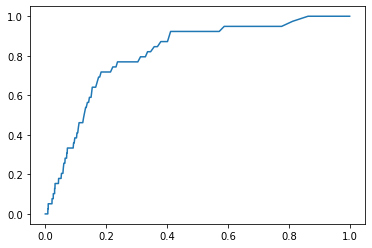

auc: 0.8104076441878051


In [67]:
rf_gs = RandomForestClassifier(random_state=0,n_estimators = 500)
rf_gs.fit(x_train_smo[rf_slf],y_train_smo.values.ravel())

fpr, tpr, thres = roc_curve(y_test, rf_gs.predict_proba(x_test_s[rf_slf])[:,1])

plt.plot(fpr, tpr)
plt.show()

score = roc_auc_score(y_test, rf_gs.predict_proba(x_test_s[rf_slf])[:,1])
print('auc:',score)

In [68]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
param = {'n_estimators':[500],'max_depth':range(5,21,5)}

gs = GridSearchCV(rf,param_grid=param,scoring='roc_auc',cv=cv)
gs_result1 = gs.fit(x_train_smo[rf_slf],y_train_smo.values.ravel())

In [69]:
gs_result1.best_params_

{'max_depth': 20, 'n_estimators': 500}

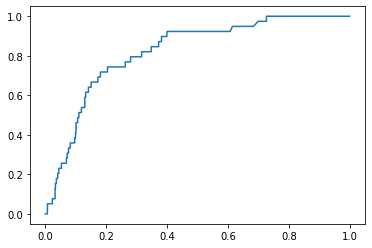

auc: 0.8211372333356248


In [70]:
rf_gs1 = RandomForestClassifier(random_state=0,n_estimators = 500,max_depth=20)
rf_gs1.fit(x_train_smo[rf_slf],y_train_smo.values.ravel())

fpr, tpr, thres = roc_curve(y_test, rf_gs1.predict_proba(x_test_s[rf_slf])[:,1])

plt.plot(fpr, tpr)
plt.show()

score = roc_auc_score(y_test, rf_gs1.predict_proba(x_test_s[rf_slf])[:,1])
print('auc:',score)

至此，模型的构建到一段落，最终构建的随机森林模型auc为82.1%  

下一步可以尝试的改进：
- 区分行业，不同行业的财务报表特点不同，对于造假的因素可能也不一致
- 尝试通过特征之间的相关性筛除一些特征，例如财务报表中关于利润的特征有些具有很强的相关性
- 进一步做一下不同模型的对比
- 尝试神经网络